In [2]:
# Cellule 1: Imports et Configuration

import pandas as pd
import numpy as np
import os
import joblib
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import warnings

# Ignorer les avertissements futurs pour garder une sortie propre
warnings.filterwarnings('ignore', category=FutureWarning)

print("Librairies importées avec succès.")

Librairies importées avec succès.


In [3]:
# Cellule 2: Génération du Dataset Synthétique (Version Corrigée)

print("Génération du jeu de données d'entraînement synthétique...")

# ... (toute la partie génération de données reste la même) ...
n_exemples = 1000
data = []
for _ in range(n_exemples):
    hs_minutes = np.random.randint(10, 240)
    taux_absence = np.random.rand() * 0.6
    historique_hs = np.random.randint(0, 25)
    score = 0
    if taux_absence > 0.4: score += 2
    if historique_hs > 10: score += 2
    if hs_minutes > 180: score -= 2
    if hs_minutes < 30: score += 1
    decision_reelle = 1 if score >= 2 else 0
    data.append([hs_minutes, taux_absence, historique_hs, decision_reelle])
columns = ['hs_minutes', 'taux_absence_service', 'nb_hs_validees_historique', 'decision_reelle']
df = pd.DataFrame(data, columns=columns)

# --- CORRECTION DU CHEMIN DE SAUVEGARDE ---
# S'assurer que le dossier 'models' existe
if not os.path.exists('./models'):
    os.makedirs('./models')

# Sauvegarder le dataset DANS le dossier 'models'
dataset_path = './models/dataset_hs_contextuel.csv' # <-- CHEMIN CORRIGÉ
df.to_csv(dataset_path, index=False)

print(f"-> Dataset de {len(df)} lignes créé et sauvegardé dans '{dataset_path}'")
print("\nAperçu des 5 premières lignes du dataset :")
print(df.head())

Génération du jeu de données d'entraînement synthétique...
-> Dataset de 1000 lignes créé et sauvegardé dans './models/dataset_hs_contextuel.csv'

Aperçu des 5 premières lignes du dataset :
   hs_minutes  taux_absence_service  nb_hs_validees_historique  \
0         182              0.429140                          7   
1          24              0.599627                          6   
2         111              0.523279                         19   
3          12              0.445047                          3   
4         111              0.222042                          8   

   decision_reelle  
0                0  
1                1  
2                1  
3                1  
4                0  



Début du processus d'entraînement et de diagnostic...

--- Distribution des classes dans le jeu de données complet ---
decision_reelle
1    558
0    442
Name: count, dtype: int64
Pourcentage de cas 'ACCEPTER' (1) : 55.80%
------------------------------------------------------------------

Données divisées : 800 pour l'entraînement, 200 pour le test.

Entraînement du modèle ACTUEL (non équilibré)...
[LightGBM] [Info] Number of positive: 446, number of negative: 354
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.557500 -> initscore=0.231022
[LightGBM] [Info] Start training from score 0.231022
[LightGBM] [Warning] No further splits with posit

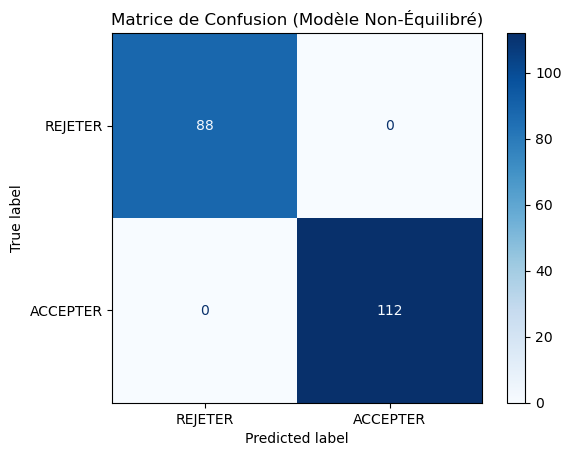


Analyse de la matrice :
Vrais REJETS (correct) : 88
Faux ACCEPTER (erreur) : 0
Faux REJETS (erreur)   : 0 <-- C'est ici le problème !
Vrais ACCEPTER (correct): 112 <-- Ce chiffre est probablement très bas

--- FIN DU DIAGNOSTIC ---


In [4]:
# ======================================================================
# Cellule 3 : Entraînement et Évaluation du Modèle (AVEC DIAGNOSTIC)
# ======================================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\nDébut du processus d'entraînement et de diagnostic...")

# Définir le chemin vers le dataset
dataset_path = './models/dataset_hs_contextuel.csv'

# 1. Charger le dataset
df_train = pd.read_csv(dataset_path)

# ------------------- DIAGNOSTIC #1 : VOIR LE DÉSÉQUILIBRE -------------------
print("\n--- Distribution des classes dans le jeu de données complet ---")
decision_counts = df_train['decision_reelle'].value_counts()
print(decision_counts)
print(f"Pourcentage de cas 'ACCEPTER' (1) : {decision_counts.get(1, 0) / len(df_train):.2%}")
print("------------------------------------------------------------------")
# --------------------------------------------------------------------------

# 2. Séparer les 'features' et la 'target'
X = df_train.drop('decision_reelle', axis=1)
y = df_train['decision_reelle']

# 3. Diviser les données pour l'entraînement et pour le test
# stratify=y est très important pour garder le même déséquilibre dans les deux sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nDonnées divisées : {len(X_train)} pour l'entraînement, {len(X_test)} pour le test.")

# 4. Créer et entraîner le modèle
print("\nEntraînement du modèle ACTUEL (non équilibré)...")
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
print("-> Modèle ACTUEL entraîné.")

# 5. Évaluer la performance
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrécision du modèle ACTUEL sur le set de test : {accuracy:.2%}")
print("\nRapport de classification détaillé (Modèle ACTUEL) :")
print(classification_report(y_test, y_pred, target_names=['REJETER (0)', 'ACCEPTER (1)']))

# ------------------- DIAGNOSTIC #2 : VOIR LES ERREURS (MATRICE DE CONFUSION) -------------------
print("\n--- Matrice de confusion du modèle ACTUEL ---")
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['REJETER', 'ACCEPTER'])

# Afficher la matrice
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion (Modèle Non-Équilibré)")
plt.show() # Cette ligne va afficher le graphique dans la sortie de la cellule

print("\nAnalyse de la matrice :")
print(f"Vrais REJETS (correct) : {cm[0, 0]}")
print(f"Faux ACCEPTER (erreur) : {cm[0, 1]}")
print(f"Faux REJETS (erreur)   : {cm[1, 0]} <-- C'est ici le problème !")
print(f"Vrais ACCEPTER (correct): {cm[1, 1]} <-- Ce chiffre est probablement très bas")
# ---------------------------------------------------------------------------------------------

# (On ne sauvegarde pas encore le modèle, on veut juste voir le diagnostic)

print("\n--- FIN DU DIAGNOSTIC ---")